# Newspaper Text Analysis Coding Challenge

### May 2024

In this coding challenge, your goal is to extract and analyze newspaper texts using the given input images and layout information. There will be four parts in this challenge:
1. Extract the text from the newspaper images
2. Convert the text into numerical representations
3. Analyze the text and visualize your results
4. Report your methods and findings

The dataset and problems are highly related to our on-going projects, and you will have a better sense of our team's work after finishing all the parts. 


**Instructions**: 
1. You should complete this challenge in Python. At present, we do not offer a version of the coding challenge in R, as there is relatively less support and development in R for running the deep learning models featured in this challenge, such as Sentence-BERT. 
2. All coding challenge prompts are given in this Jupyter notebook, but you can write your own functions outside of the notebook if that's preferable. We provide function skeletons in this Jupyter notebook, but please feel free to make any changes to them that work best for your code. 
3. Please provide clean and easy-to-read code. Add comments when necessary. 
4. We've designed this challenge so as to make it suitable for your local coding environments, e.g., no model training on a GPU is expected or necessary. If for some reason you find a need to train a model with a GPU, the easiest way to proceed is to upload the notebook to [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb) and use the free compute resources available there. 

## Part 1: Convert Images to Text

Most historical documents (e.g., newspapers) are only available to researchers in the form of image scans. The first step in analyzing the content of a historical document is therefore to perform image-to-text conversion. This is a combination of Layout Analysis and Optical Character Recognition (OCR), whereby you parse the arrangement of "layout objects" (e.g., headlines, author bylines) in documents and turn the image data inside each layout object region into a computable text. Luckily, a team member has just finished the layout analysis for you! With the given *layout information* and *images* as inputs, you need to generate structured data in the form of full newspaper articles. Structuring the OCRed text data as newspaper articles using layout information is a prerequisite for performing further analysis on the content of historical document scans.

**Input**:

- A list of images and layout information: `List[Tuple(image_path, layout_info)]`
- The image and layout information files are stored in the `dataset/images` folder and `dataset/layout.json` file
- The `layout.json` will be stored in a format like the [COCO format](https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch): 
    
    ```
    {
        'annotations': [
            # Specifies the rectangular boxes and types for 
            # each layout element 
            {"id": 1,        # The id of the anno object
             "bbox": [],     # (x_top_left, y_top_left, width, height) of the bounding box
             "image_id": 1,  # The associated image_id
             "category_id":2 # The category_id 
            }, ...
        ],
        'images': [
            {"id": 397133,
             "height": 427,
             "width": 640,
             "file_name": "000000397133.jpg"
            }, ...
        ],
        'categories': [
            {"supercategory": None, # We don't use this
             "id": 1,               # The category_id used for each annotation
             "name": "person"       # The name for the categories 
             }, ...
        ],
        'reading_orders': [
            # Specifies the reading order of different annotation objects 
            # The object of `end_id` comes after the object of `start_id`
            # Not all objects have the reading orders 
            {
              "from_id": 435,
              "to_id": 434,
              "image_id": 9
            }, ...
        ]
    }
    ```


**Output**:
    
- A list of parsed article information: `List[Dict(article_info)]`
    ```
    [
        {'id': 0,            # An articled id generated by you (better be continuous from 0 to len(articles))
         'headline': '',     # The headline of an article. Could be empty 
         'text': '',         # The body text of the article
         'image_id': 12,     # The id of the image where the article appears 
         'anno_ids': [31,33] # The ids of the associated layout regions 
        }, ...
    ]
    ```
    
**Steps**:

1. Iterate through the layout information.
2. Using the layout info, perform OCR on layout object regions with the open source tool TesseractOCR.
3. Join the layout object OCR texts using the reading orders available in the layout info.
4. Combine all the outputs and save in the aforementioned format.

**Notes**:

- You might need to install the [TesseractOCR engine](https://github.com/tesseract-ocr/tesseract#installing-tesseract) and its [Python wrapper](https://github.com/madmaze/pytesseract) on your computer to perform the OCR.
- You might find some functions in the [Layout Parser Library](https://layout-parser.readthedocs.io/en/latest/) helpful.
- For the reading orders:
    - The below image (or the `reading-order.png` file in the same folder as the Jupyter notebook document) shows an example of the layout objects in a full article and their reading order. 
    - A full article is usually composed of several text regions of different types. They are usually associated by several one-directional reading order pointers, illustrated by red arrows in the figure. The `from_id` is the annotation (object) id for the starting box, and the `to_id` is for the ending box. 
    - For the end of the article, there **won't** be an extra reading order point to the next title. So the reading order sequence within a full article is terminated at the last article box. 
    - Sometimes we will have reading orders for images and their captions. You can ignore these reading orders. 
    ![reading-order](reading-order.png)

In [ ]:
# $ pip install -r requirements.txt

In [1]:
import os
import json
import re
from PIL import Image
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' # Please change the PATH here
from typing import List, Dict, Tuple

parent_dir = os.path.dirname(os.getcwd())

def load_json(filename: str) -> Dict:
    with open(filename, 'r') as file:
        return json.load(file)

def ocr_image_region(image: Image, bbox: Tuple[int, int, int, int]) -> str:
    region = image.crop((bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]))
    return pytesseract.image_to_string(region, lang='eng')

def clean_ocr_text(text: str) -> str:
    text = text.replace('‘', "'").replace('’', "'").replace('“', '"').replace('”', '"')
    text = re.sub(r'(\w)-\n(\w)', r'\1\2', text) # Remove hyphens between words at the end of the line
    text = re.sub(r'(?<=[.!?;:])\n(?=\w)', ' ', text)
    text = re.sub(r'(?<=[a-zA-Z0-9,])\n(?=[a-zA-Z0-9])', ' ', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r'\b(\w{2,}),\s*([A-Z])', r'\1. \2', text.strip(",")) # Some "." are mistaken as "." by ocr
    text = re.sub(r'(\d),(?=\d{3}\b)', r'\1', text)
    text = text.strip()
    text = text[:-1] + "." if text and text.endswith(",") else text
    return text

def parse_newspaper_scan(images_info: List[Dict], annotations: List[Dict], categories: List[Dict], reading_orders: List[Dict]) -> List[Dict]:
    category_map = {category['id']: category['name'] for category in categories} 
    
    image_annotations = {image['id']: [] for image in images_info}
    for annotation in annotations:
        image_annotations[annotation['image_id']].append(annotation)
    
    articles = []
    article_id = 0
    
    for image_info in images_info:
        image_path = image_info['file_name']
        image_id = image_info['id']
        image = Image.open(image_path)
        
        current_annotations = image_annotations[image_id]
        current_reading_orders = [ro for ro in reading_orders if ro['image_id'] == image_id]
        
        ro_map = {ro['from_id']: ro['to_id'] for ro in current_reading_orders}
        
        all_to_ids = {ro['to_id'] for ro in current_reading_orders}
        start_ids = [ann['id'] for ann in current_annotations if ann['id'] not in all_to_ids] # Find the starting id
        
        for start_id in start_ids:
            current_article = {
                'id': article_id,
                'headline': '',
                'text': '',
                'image_id': image_id,
                'anno_ids': []
            }
            
            # Iterate through the layout information
            current_id = start_id
            while current_id:
                annotation = next((ann for ann in current_annotations if ann['id'] == current_id), None)
                if annotation:
                    category_name = category_map[annotation['category_id']]
                    text = ocr_image_region(image, annotation['bbox'])
                    cleaned_text = clean_ocr_text(text)
                    
                    if category_name == 'headline':
                        current_article['headline'] += cleaned_text + " "
                    else:
                        current_article['text'] += cleaned_text + " "
                    
                    current_article['anno_ids'].append(current_id)
                
                current_id = ro_map.get(current_id, None)
                
            current_article['headline'] = current_article['headline'].strip()
            current_article['text'] = current_article['text'].strip()
            
            articles.append(current_article)
            article_id += 1
    
    return articles

# Read the json and perform OCR
file_path = os.path.join(parent_dir, "dataset","layout.json")
with open(file_path, 'r') as f:
    layout_data = json.load(f)
images_info = layout_data['images']
annotations = layout_data['annotations']
categories = layout_data['categories']
reading_orders = layout_data['reading_orders']

for image in images_info:
    image['file_name'] = os.path.join(parent_dir,"dataset","images",image["file_name"])
    
parsed_articles = parse_newspaper_scan(images_info, annotations, categories, reading_orders) # Perform OCR

"""print(json.dumps(parsed_articles, indent=2, ensure_ascii=False))"""

output_file_path = os.path.join(parent_dir,"results","parsed_articles.json")
with open(output_file_path, "w", encoding="utf-8") as output_file:
    json.dump(parsed_articles, output_file, indent=2, ensure_ascii=False)

print(f"JSON data saved to {output_file_path}")

JSON data saved to C:\Users\Jingwen Shi\Desktop\coding_challenge_may2024\results\parsed_articles.json


## Part 2: Run SBERT on the Text 

After parsing the articles from the images, we want to use natural language processing (NLP) methods to analyze the text. As texts are usually heterogeneous, we use novel deep learning models like [Sentence-BERT (SBERT)](https://arxiv.org/abs/1908.10084) to convert them into dense numerical representations (i.e., vectors) to enable meaningful quantitative analysis. Fortunately, SBERT implementations and pre-trained model weights are [open source](https://sbert.net/). Thus, we don't need to spend a huge amount of time implementing the models of interest to us and training them from scratch. 

**Input**: 
- The list of articles from Part 1

**Output**:
- An $M\times N$ matrix where each row is the embedding (dense numerical representation) vector for that article 
    - $M$: len(articles)
    - $N$: The embedding dimension. 
    
**Steps**:
1. Build the SBERT model and load the weights from the pretrained model `all-MiniLM-L6-v2`. 
2. For each article, use SBERT to "embed" (create a dense numerical representation of) the text. 
    - You can refer to this official documentation for creating the sentence embeddings using SBERT: https://sbert.net/index.html
    - Questions to consider:
        - How do you deal with the noise (e.g., spelling mistakes, punctuation errors) in the OCRed text? Is this noise a problem for SBERT?
        - How do you handle embedding very long articles?  

**Notes**:
- You will need to install and learn to use the official [sentence-transformer library](https://sbert.net/docs/installation.html) and their SBERT implementation and pre-trained weights.
- You can consider generating embedding vectors for just the headlines of each article, which are usually short sentences and may prove more manageable to work with. If you do so, provide a brief discussion of the tradeoffs involved in this decision in Part 4, and whether or not you would want to do this in practice.


In [1]:
import os
import numpy as np
import json
import re
from sentence_transformers import SentenceTransformer
# Using Rapidfuzz to correct spelling, for comparison
"""
from rapidfuzz import process, fuzz
import nltk
nltk.download('words')
from nltk.corpus import words
dictionary = words.words()
"""

parent_dir = os.path.dirname(os.getcwd())

file_path = os.path.join(parent_dir, "results","parsed_articles.json")
with open(file_path, 'r', encoding='utf-8') as file:
    articles = json.load(file)

model = SentenceTransformer('all-MiniLM-L6-v2') # SBERT model
LENGTH_THRESHOLD = 512 # This can be tuned
    
def preprocess_text(text):
    text = re.sub(r"([a-zA-Z])(?=\s+[A-Z])", r"\1. ", text) # Deal with punctuation issues
    text = re.sub(r'[^\w\s,.]', '', text)
    # Using Rapidfuzz to correct spelling, for comparison
    """
    words = text.split()
    corrected_words = []
    for word in words:
        best_match = process.extractOne(word, dictionary, scorer=fuzz.WRatio, score_cutoff=70)
        if best_match:
            corrected_words.append(best_match[0])
        else:
            corrected_words.append(word)
    text = ' '.join(corrected_words)
    """
    return text

def embed_short_article(article):
    return model.encode(article)

def embed_long_article(article, max_chunk_length=256):
    """Split the article into chunks"""
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', article)
    chunks = []
    current_chunk = []
    current_length = 0
    
    for sentence in sentences:
        sentence_length = len(sentence.split())
        if current_length + sentence_length > max_chunk_length:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]
            current_length = sentence_length
        else:
            current_chunk.append(sentence)
            current_length += sentence_length
    
    if current_chunk:
        chunks.append(" ".join(current_chunk))
        
    chunk_embeddings = np.array([model.encode(chunk) for chunk in chunks])
    article_embedding = np.mean(chunk_embeddings, axis=0) # Embed each chunk and then average
    
    return article_embedding

def automatic_embed_article(article, length_threshold=LENGTH_THRESHOLD):
    tokens = article.split()
    num_tokens = len(tokens)
    if num_tokens <= length_threshold:
        return embed_short_article(article)
    else:
        return embed_long_article(article)
    
def embed_newspaper_texts(articles, output_file_path):
    embeddings = []
    for article in articles:
        if 'text' in article and article['text'].strip() != '':
            text = preprocess_text(article['text'])
            embedding = automatic_embed_article(text)
            embeddings.append(embedding)
            
    embeddings = np.array(embeddings)
    
    print("Shape of embeddings:", embeddings.shape)
    """print("Embeddings Matrix (first 2 rows):\n", embeddings[:2])"""
    np.savetxt(output_file_path, embeddings, delimiter=",")
        
    return embeddings

if __name__ == "__main__":
    output_file_path = os.path.join(parent_dir,"results","article_embeddings.csv")
    embeddings = embed_newspaper_texts(articles, output_file_path)



Shape of embeddings: (158, 384)


In [4]:
## COMPARE TWO EMBEDDINGS (1- with noise; 2- correct spelling)

"""
import os
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

parent_dir = os.path.dirname(os.getcwd())

def evaluate_embeddings(embeddings1, embeddings2):
    similarities = []
    for emb1, emb2 in zip(embeddings1, embeddings2):
        similarity = 1 - cosine(emb1, emb2) # Average cosine similarity
        similarities.append(similarity)
    return np.mean(similarities)

csv_path1 = os.path.join(parent_dir,"results","article_embeddings.csv")
csv_path2 = os.path.join(parent_dir,"results","article_embeddings_robust.csv")

embeddings1 = pd.read_csv(csv_path1, header=None).values
embeddings2 = pd.read_csv(csv_path2, header=None).values

embeddings1 = np.array(embeddings1)
embeddings2 = np.array(embeddings2)

average_similarity = evaluate_embeddings(embeddings1, embeddings2)

print("Average Cosine Similarity:", average_similarity)
"""

Average Cosine Similarity: 0.6519628783514516


# Part 3: Visualization and Analysis 

It's hard for humans to directly interpret these dense, high-dimensional embedding vectors. Therefore, to make the results of SBERT inference more transparent and intelligible, it is common to (a) perform dimensionality reduction on and (b) cluster the embedding vectors. In this part, you are required to analyze the vectors you generated in a similar way. 

**Input**:
- The embedding matrix/table from Part 2

**Output**:
- Visualization of the embedding vectors in a low-dimension space 
- Clustering results of the embedding vectors 
- Interpretation of the results, including but not limited to: 
    - Do the clusters of vectors look meaningful? 
    - Could you find clusters of important topics? 

**Steps**:
1. Choose an appropriate dimensionality reduction method and apply it to the embedding matrix. 
2. Choose an appropriate clustering method and apply it to the embedding matrix or the embedding matrix after dimensionality reduction.
3. Visualize the results using the tools that are most familiar to you and save the results.

**Notes**:
- Scikit-learn provides many handy functions for [clustering](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster) and dimensionality reduction (e.g., [matrix decomposition](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition), [manifold learning methods such as t-SNE](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold)).
- You can visualize the results in 2D or 3D. For drawing 3D plots, you can consider using [plotly](https://plotly.com/). 

OMP_NUM_THREADS: 1
Thread limits set within threadpool_limits context.


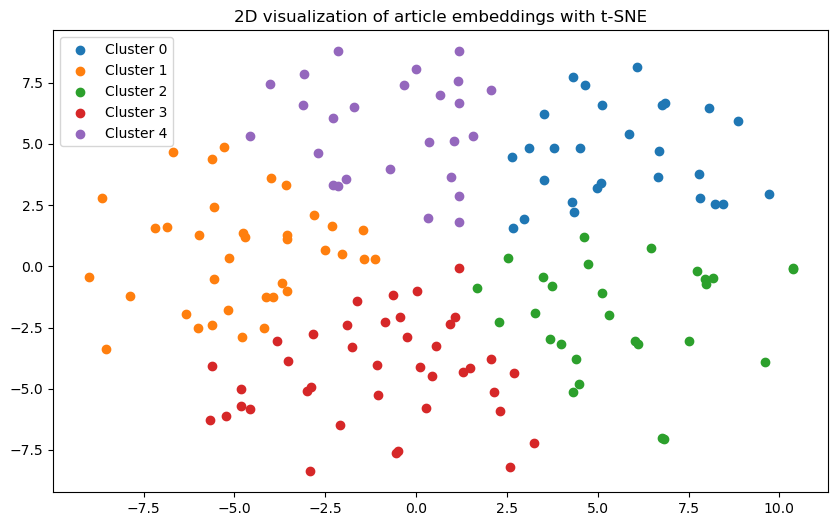


Cluster 0 - 28 articles:


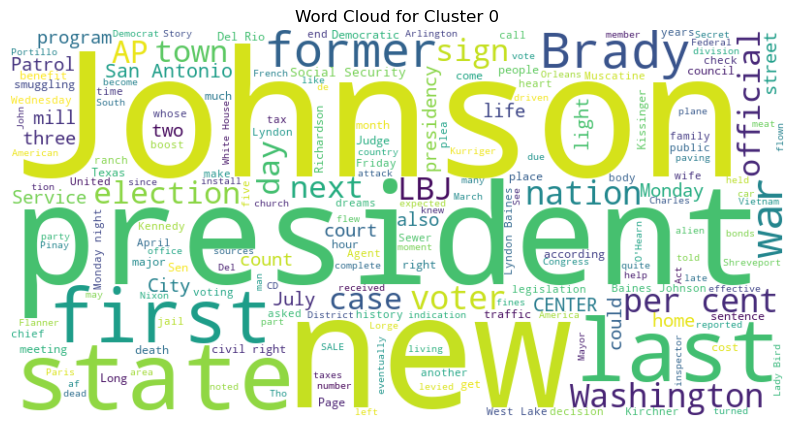


Cluster 1 - 36 articles:


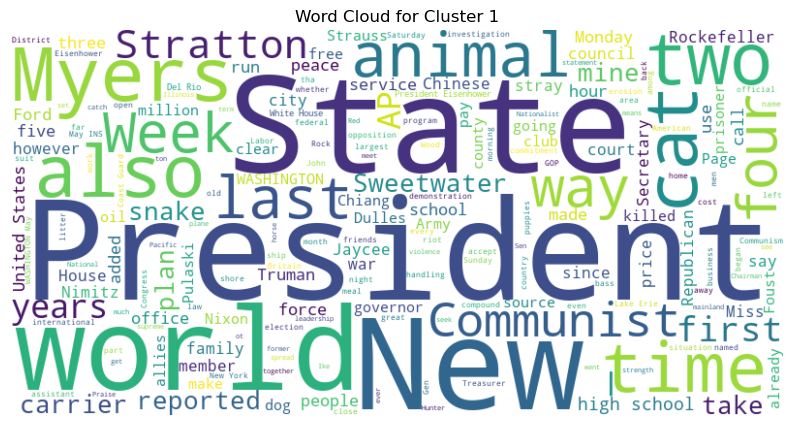


Cluster 2 - 28 articles:


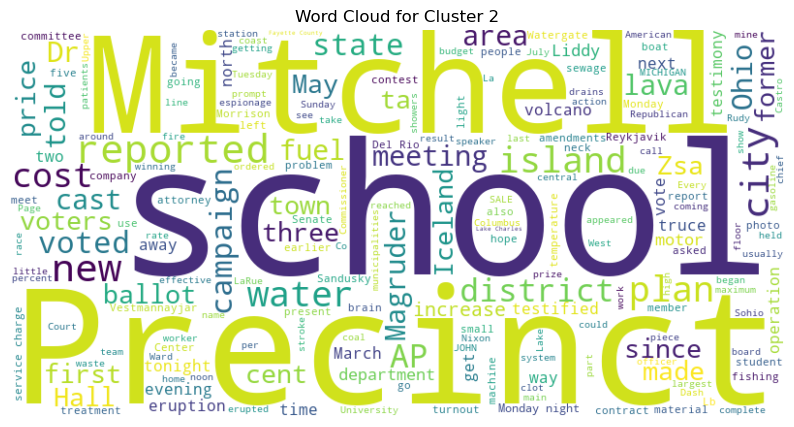


Cluster 3 - 40 articles:


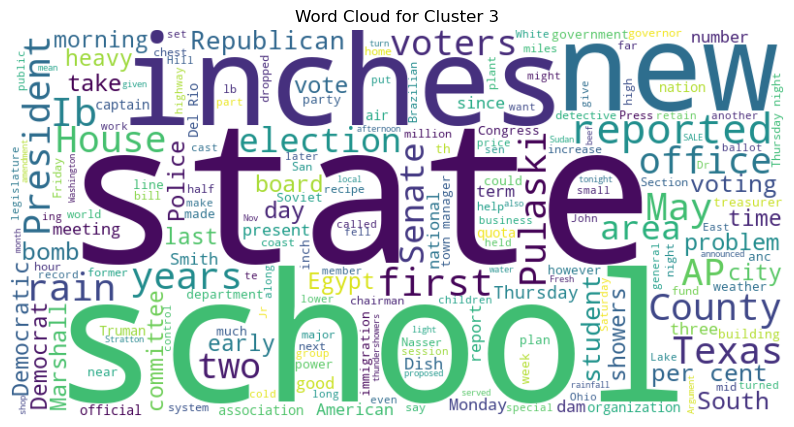


Cluster 4 - 26 articles:


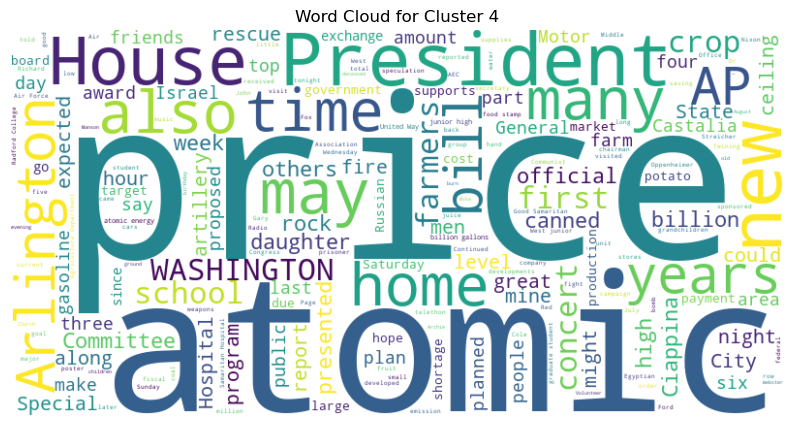

In [3]:
### I DID BOTH FOR 2- AND 3-DIMENSION.
#### THIS IS FOR 2-DIMENSION

import os
parent_dir = os.path.dirname(os.getcwd())

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

print("OMP_NUM_THREADS:", os.getenv("OMP_NUM_THREADS")) # Confirm the environment being set

import numpy as np
from threadpoolctl import threadpool_limits
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import plot as plotly_plot
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import json
import string

stop_words = set(stopwords.words('english'))
custom_stopwords = set(["said","would","year","today","one","Mr","Mrs","Dr"])
custom_stopwords.update(string.ascii_uppercase)
all_stopwords = stop_words.union(custom_stopwords)

output_dir = os.path.join(parent_dir, 'results', 'plot')
os.makedirs(output_dir, exist_ok=True)

def clustering_and_viz(embs):
    with threadpool_limits(limits=1, user_api='blas'):
        print("Thread limits set within threadpool_limits context.")
        
        tsne = TSNE(n_components=2, random_state=42) # Dimensionality Reduction
        embeddings_2d = tsne.fit_transform(embs)
        
        n_clusters = 5
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        clusters = kmeans.fit_predict(embeddings_2d)
        
        # Visualization
        plt.figure(figsize=(10, 6))
        for i in range(n_clusters):
            plt.scatter(embeddings_2d[clusters == i, 0], embeddings_2d[clusters == i, 1], label=f"Cluster {i}")
        plt.title('2D visualization of article embeddings with t-SNE')
        plt.legend()
        plot_path = os.path.join(output_dir, 'scatter_plot_2D_2comps.png')
        plt.savefig(plot_path)
        plt.show()
        plt.close()
        
        html_content = "<html><head><title>Clustering Results</title>"
        html_content += "<script src='https://cdn.plot.ly/plotly-latest.min.js'></script></head><body>"
        html_content += "<h1>2D Visualization</h1>"
        html_content += f"<img src='plot/scatter_plot_2D_2comps.png' /><br>"
        html_content += "<h1>Word Clouds for Clusters</h1>"
    
        # Cluster topics
        for i in range(n_clusters):
            cluster_indices = np.where(clusters == i)[0]
            cluster_articles = articles_array[cluster_indices]
            print(f"\nCluster {i} - {len(cluster_articles)} articles:")

            # Wordclouds for clusters
            cluster_text = ' '.join(cluster_articles.flatten())
            wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords).generate(cluster_text)
            plt.figure(figsize=(10, 6))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f'Word Cloud for Cluster {i}')
            plt.axis('off')
            plt.show()

            wordcloud_path = os.path.join(output_dir, f'wordcloud_cluster_{i}_2comps.png')
            wordcloud.to_file(wordcloud_path)

            html_content += f"<h2>Cluster {i}</h2><img src='{wordcloud_path}' /><br>"
        html_content += "</body></html>"
        html_path = os.path.join(parent_dir,"results","visualization_results_2D.html")
        with open(html_path, "w") as html_file:
            html_file.write(html_content)
            
# Perform clustering and visualization
file_path_embeddings = os.path.join(parent_dir,"results","article_embeddings.csv")
file_path_articles = os.path.join(parent_dir,"results","parsed_articles.json")

embeddings = pd.read_csv(file_path_embeddings, header=None).values

with open(file_path_articles, 'r', encoding='utf-8') as f:
    articles_json = json.load(f)
article_texts = [article['text'] for article in articles_json]
articles_array = np.array(article_texts)

clustering_and_viz(embeddings)


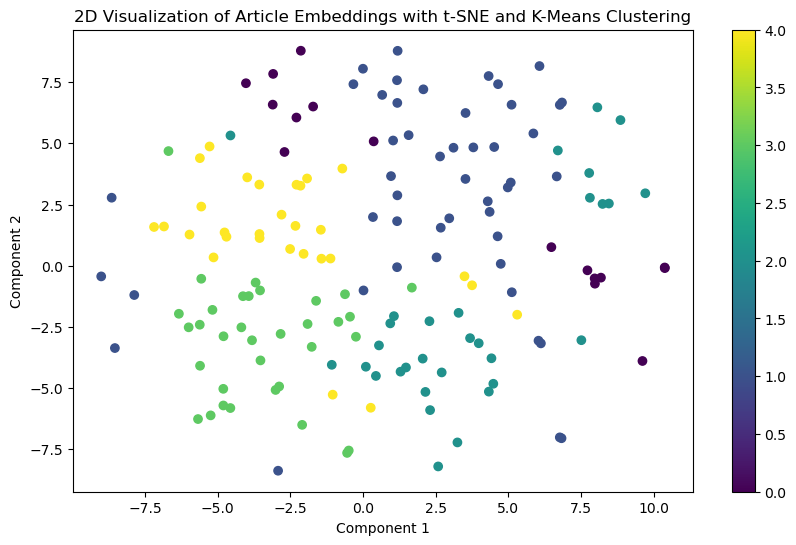


Cluster 0 - 16 articles:


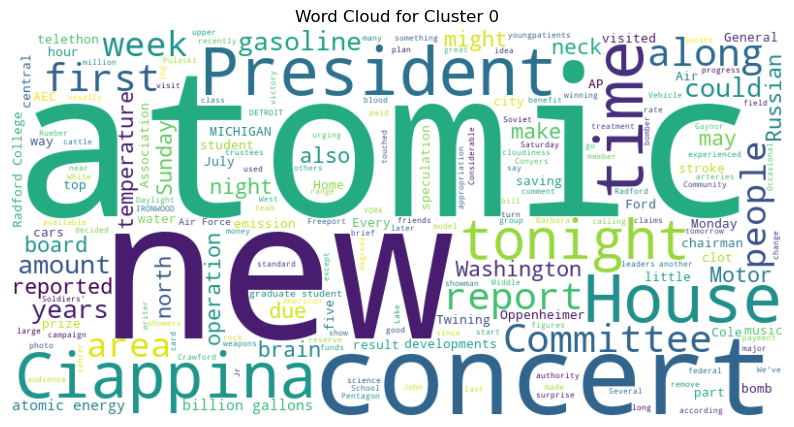


Cluster 1 - 48 articles:


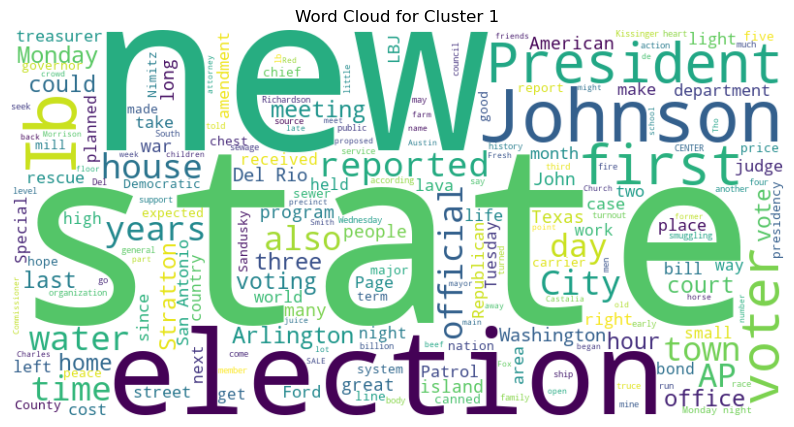


Cluster 2 - 31 articles:


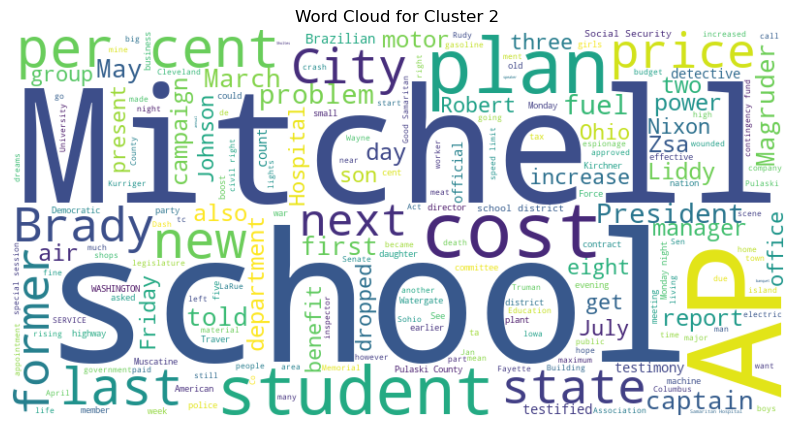


Cluster 3 - 34 articles:


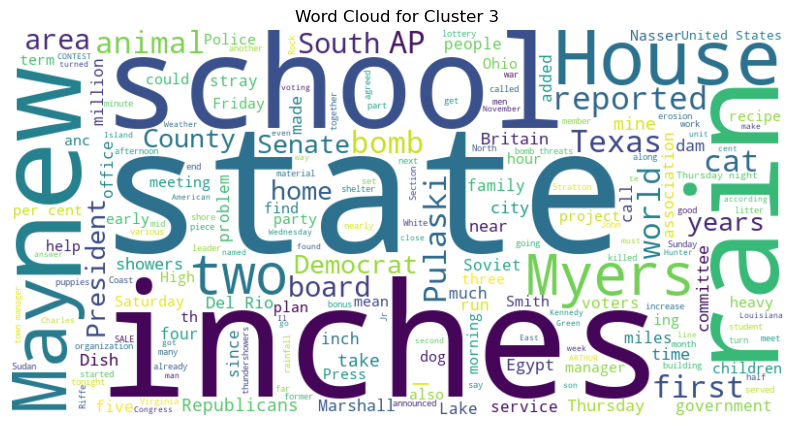


Cluster 4 - 29 articles:


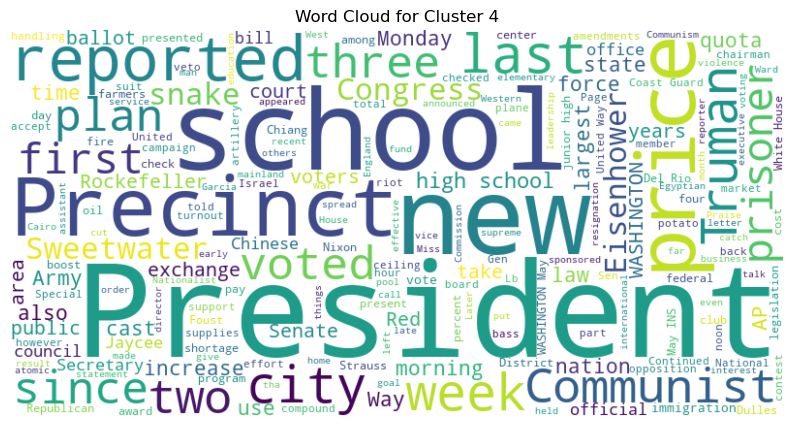

In [4]:
#### THIS IS FOR 3-DIMENSION

import os
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from wordcloud import WordCloud
import json
import string

parent_dir = os.path.dirname(os.getcwd())

init_notebook_mode(connected=True)
stop_words = set(stopwords.words('english'))
custom_stopwords = set(["said","would","year","today","one","Mr","Mrs","Dr"])
custom_stopwords.update(string.ascii_uppercase)
all_stopwords = stop_words.union(custom_stopwords)

os.environ["OMP_NUM_THREADS"] = "1" 

output_dir = os.path.join(parent_dir, 'results', 'plot')
os.makedirs(output_dir, exist_ok=True)
        
def clustering_and_viz_2d_3d(embs):
    tsne = TSNE(n_components=2, random_state=42) # Dimensionality Reduction to 2D using t-SNE
    embeddings_2d = tsne.fit_transform(embs)
    
    pca = PCA(n_components=3) # Dimensionality Reduction to 3D using PCA
    embeddings_3d = pca.fit_transform(embs)
    
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(embs)
    
    # 2D Visualization
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('2D Visualization of Article Embeddings with t-SNE and K-Means Clustering')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plot_path = os.path.join(output_dir, 'scatter_plot_2D.png')
    plt.savefig(plot_path)
    plt.show()
     
    # 3D Visualization
    trace = go.Scatter3d(
        x=embeddings_3d[:, 0],
        y=embeddings_3d[:, 1],
        z=embeddings_3d[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=clusters,
            colorscale='Viridis',
            opacity=0.8,
            showscale=True
        )
    )
    plotly_fig = go.Figure([trace])
    plotly_html_3D = plotly_plot(plotly_fig, output_type='div', include_plotlyjs=False)
    iplot(plotly_fig)

    html_content = "<html><head><title>Clustering Results</title>"
    html_content += "<script src='https://cdn.plot.ly/plotly-latest.min.js'></script></head><body>"
    html_content += "<h1>2D Visualization</h1>"
    html_content += f"<img src='plot/scatter_plot_2D.png' /><br>"
    html_content += "<h1>3D Visualization</h1>"
    html_content += f"{plotly_html_3D}"
    html_content += "<h1>Word Clouds for Clusters</h1>"
    
    
    # Cluster topics
    for i in range(n_clusters):
        cluster_indices = np.where(clusters == i)[0]
        cluster_articles = articles_array[cluster_indices]
        print(f"\nCluster {i} - {len(cluster_articles)} articles:")
            
        # Wordclouds for clusters
        cluster_text = ' '.join(cluster_articles.flatten())
        wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=all_stopwords).generate(cluster_text)
        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Cluster {i}')
        plt.axis('off')
        plt.show()
        
        wordcloud_path = os.path.join(output_dir, f'wordcloud_cluster_{i}.png')
        wordcloud.to_file(wordcloud_path)
        html_content += f"<h2>Cluster {i}</h2><img src='{wordcloud_path}' /><br>"
    html_content += "</body></html>"
    html_path = os.path.join(parent_dir,"results","visualization_results_3D.html")
    with open(html_path, "w") as html_file:
        html_file.write(html_content)
            
            
# Perform clustering and visualization
file_path_embeddings = os.path.join(parent_dir,"results","article_embeddings.csv")
file_path_articles = os.path.join(parent_dir,"results","parsed_articles.json")

embeddings = pd.read_csv(file_path_embeddings, header=None).values
with open(file_path_articles, 'r', encoding='utf-8') as f:
    articles_json = json.load(f)
article_texts = [article['text'] for article in articles_json]
articles_array = np.array(article_texts)

clustering_and_viz_2d_3d(embeddings)


## Part 4: Report Your Methods and Findings 

As a researcher, being able to explain your methods and findings clearly is very important. Therefore, we would like you to write a short report that:
1. documents your implementation and provides extra notes about your code;
2. analyzes the visualization results; and 
3. highlights any of the challenges you encountered or questions you faced in this process. 


## What to Submit

Congratulations! You've finished all of the tasks! We believe you may now have a better understanding of our work, and, hopefully, you have also learned something about deep NLP and data analysis in the process. 

To submit your completed coding challenge, you can zip all your files and send the zip file to the specified email address. Please include all the following files in your zip file: 

1. A `code` folder that has all the code (Jupyter notebooks or Python files) for generating the results:
    - Please make sure the code is runnable. 
    - Provide documentation and comments whenever necessary. 
    - You can also specify any Python libraries and versions necessary to run your code in a `requirements.txt` file. See [this post](https://note.nkmk.me/en/python-pip-install-requirements/).  
2. A `results` folder that has the intermediate results:
    - The article JSON file from Part 1 (note: you can just save the output article list as a JSON file using `json.dump`). 
    - The embedding matrix from Part 2 (note: you can consider using [`numpy.save`](https://numpy.org/doc/stable/reference/generated/numpy.save.html) to save the matrix, or use [`pandas.to_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) if you have been storing the matrix as a `DataFrame`). 
    - The visualization images or HTMLs from Part 3.
3. The short report.

Thank you for completing this challenge. We will get back to you shortly! 